# Compute Sun and Moon Altitude for a Location with `astropy` - Pt. 2

The [previous part](https://github.com/egemenimre/satstuff/blob/master/notebooks/astropy/Sun_Moon_Alt.ipynb) demonstrated how to set up a simple Sun and Moon Altitude calculator for a location on Earth. This second part will focus on using interpolators to estimate the Sun rise/set times as well as max/min altitudes and times.

The configuration is similar to the [previous part](https://github.com/egemenimre/satstuff/blob/master/notebooks/astropy/Sun_Moon_Alt.ipynb), so I will not go into detailed explanations:

In [2]:
from astropy.coordinates import EarthLocation
from astropy import units as u
from astropy.time import Time, TimeDelta

import pytz

# Init location - default Ellipsoid is WGS84
istanbul = EarthLocation(lat=41.015137, lon=28.979530, height=0 * u.m)
ist_timezone = pytz.timezone("Turkey")
utc_timezone = pytz.timezone("utc")

# Time analysis config (stepsize, duration, init time)
init_time = Time("2020-04-12T00:00:00", scale="utc")
dt = TimeDelta(10 * 60.0, format="sec")  # stepsize
duration = TimeDelta(1.0, format="jd")  # duration

Next step is to set up the Alt-Az frames for each time step and initialise the Sun vectors in these Alt-Az frames. Note that, the `get_sun` method generates _apparent_ (i.e., corrected for light time and stellar aberrations) vectors with relatively low accuracy (though more than accurate enough for our purposes).

In [3]:
import numpy as np
from astropy.coordinates import AltAz, get_sun

# Generate observation time list
dt_list = dt * np.arange(0, duration.sec / dt.sec, 1)
obs_times: Time = init_time + dt_list

# Init the frames for each time
alt_az_frames: AltAz = AltAz(location=istanbul, obstime=obs_times)
    
# Generate the Sun coords (low precision apparent pos) in Alt Az
sun_alt_az_list = get_sun(obs_times).transform_to(alt_az_frames)

So far, so previous part. Now, we will set up the interpolators to convert the discrete time vs. altitude values to a continuous function approximating this data set. This is via the `interpolation` engine from Scipy. This reasonably common interface has a number different implementations.

However, the first step is to flatten the `Time` objects into simple floats (in our case unixtime). Note that this might involve some loss of precision - `Time` object practically can hold up to two floats to represent a single time instant, whereas unixtime is a single float.


In [4]:
from scipy import interpolate

# Convert time list into a float list for use with the interpolator (possible loss of precision)
t__float_list = sun_alt_az_list.obstime.to_value("unix")

# Init interpolators (for splines, root finding possible for 3rd degree (cubics) only)
sun_alt_interpolator = interpolate.Akima1DInterpolator(t__float_list, sun_alt_az_list.alt.deg)
sun_interpolator_deriv_alt = sun_alt_interpolator.derivative()

While we have used `Akima1DInterpolator`, there is ample choice of interpolators offered by Scipy. Also note that we have immediately taken the derivative of this interpolator function. This will come handy later. 

Be advised that Spline Interpolators support root finding for 3<sup>rd</sup> degree only - and once you take the derivative of a 3<sup>rd</sup> order, you end up with a 2<sup>nd</sup> order and you cannot take roots any more. Important if you want to find the second roots (e.g. max/min of a function).

Now that we have the interpolators, let's check whether they agree with the true result. For this, we evaluate the interpolated altitude at a specific time with the true Sun altitude. The time is intentionally chosen randomly to make sure we don't hit any know points. You can try it and see how much you differ from the true result. You can also change the `dt` parameter above to see whether a coarser sampling actually worsens the quality of the interpolation. 

In [5]:
interp_time: Time = Time("2020-04-12 08:04:23.31221", scale="utc")

# Compute interpolated altitude
sun_interp_alt = sun_alt_interpolator(interp_time.to_datetime(utc_timezone).timestamp())

# Compare with true altitude
print(f"Sample interpolation result at {interp_time.to_datetime(ist_timezone)}")
print(
    f"Sun true alt (deg)        : {get_sun(interp_time).transform_to(AltAz(location=istanbul, obstime=interp_time)).alt.deg}")
print(f"Sun interpolated alt (deg): {sun_interp_alt}")

Sample interpolation result at 2020-04-12 11:04:23.312210+03:00
Sun true alt (deg)        : 48.277255902312945
Sun interpolated alt (deg): 48.277306486311105


Checking the results, it looks like they agree to about 0.05 millidegree level. Should be more than enough for most applications.

Going back to our initial aim, we would like to find the sunrise, sunset and sun max/min altitude times. Mathematically, the first two corresponds to the _roots_ of this function, where its altitude value is equal to zero. Fortunately, the interpolator readily offers them through the roots() function.

Each root is a sunrise or sunset event, but we don't know which is which. We go through the roots and check the derivatives at these instances. If the first derivative value at the root is positive, the altitude values are increasing - the sun is rising. If the derivative is negative, the sun is going down. So we know which root corresponds to which event.

Finally, note the switch between unixtime float and Astropy `Time` object, while being careful for the local timezone and [UTC](https://en.wikipedia.org/wiki/Coordinated_Universal_Time).

In [6]:
rise_set_events = sun_alt_interpolator.roots()
for event_time in rise_set_events:
    deriv = sun_interpolator_deriv_alt(event_time)
    if deriv > 0:
        sun_rise_time = Time(event_time, format="unix", scale="utc")
        print("Sunrise time:")
    else:
        sun_set_time = Time(event_time, format="unix", scale="utc")
        print("Sunset time:")
    print(Time(event_time, format="unix", scale="utc").to_datetime(timezone=ist_timezone))

Sunrise time:
2020-04-12 06:33:48.766705+03:00
Sunset time:
2020-04-12 19:36:27.265486+03:00


We do a similar trick to find the max/min times. We check the roots of the _derivative_ interpolator, which gives us the max/min points. To understand which is which, we check which one have a positive altitude at this time and which one has the negative.

Be careful, this simplistic code would not work at a location where the Sun never goes above or below the horizon. We would then need to compare the two altitude values to see which one is greater. But for illustrative purposes this is good enough. In our case, one altitude is almost 58 degrees above horizon and the other is almost 40 degrees below horizon, so it is easy to tell which is which. 

In [7]:
min_max_events = sun_interpolator_deriv_alt.roots()
for event_time in min_max_events:
    pos = sun_alt_interpolator(event_time)
    if pos > 0:
        print("Sun highest time:")
    else:
        print("Sun lowest time:")
    print(Time(event_time, format="unix", scale="utc").to_datetime(timezone=ist_timezone))
    print(f"Altitude (deg) : {sun_alt_interpolator(event_time)}")

Sun highest time:
2020-04-12 13:04:56.620527+03:00
Altitude (deg) : 57.909137222526745
Sun lowest time:
2020-04-13 01:04:24.888192+03:00
Altitude (deg) : -39.880061509214244


Like the previous installment, we then present the results in a nice plot that shows the altitude over the duration.

One trick is the addition of vertical lines that show Sunrise and Sunset times on the plot. Unsurprisingly, they are at the roots of the altitude function, providing a nice visual confirmation of our results.

Finally, you can find the complete code [here in GitHub](https://github.com/egemenimre/satstuff/blob/master/examples/astropy/sun_rise_set.py).

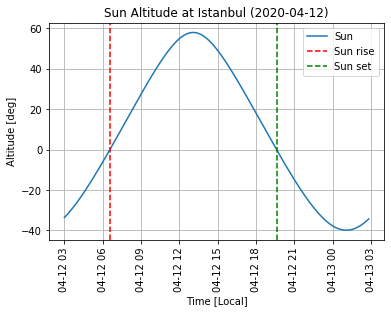

In [10]:
%matplotlib inline

# ***** Plot the Sun Alt angles *****
time_list = obs_times.to_datetime(timezone=ist_timezone)
plt.plot(time_list, sun_alt_az_list.alt.deg)
plt.grid()

# Add sunrise and sunset markers
plt.axvline(sun_rise_time.to_datetime(timezone=ist_timezone), color="red", ls="dashed")
plt.axvline(sun_set_time.to_datetime(timezone=ist_timezone), color="green", ls="dashed")

# autoformat the time labels on x-axis
# plt.gcf().autofmt_xdate()
plt.xticks(rotation=90)

plt.title(f"Sun Altitude at Istanbul ({init_time.to_datetime(timezone=ist_timezone).date()})")
plt.xlabel("Time [Local]")
plt.ylabel("Altitude [deg]")
plt.legend(["Sun", "Sun rise", "Sun set"])

plt.show()